# Logistic Regression

## Maxwell Nielsen

## Section 001

## 11/14/2022

In [19]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pandas as pd
import statsmodels.api as sm
import time
from matplotlib import pyplot as plt

## Problem 1

Create a classifier called `LogiReg` that accepts an $(n \times 1)$ array $y$ of binary labels ($0$'s and $1$'s) as well as an $(n \times d)$ array $X$ of data points. Write a `fit()` method that finds and saves the optimal $\widehat{\boldsymbol{\beta}}$.

## Problem 2

Write a method called `predict_prob()` that accepts an $(n \times d)$ array $x\_test$ and returns $P(Y=1 | x\_test)$. Also write a method called `predict()` that calls `predict_prob()` and returns an array of predicted labels ($0$'s or $1$'s) for the given array $x\_test$.

In [35]:
class LogiReg():
    """ input:
        y: nparray(n, 1) taking values only in {0,1}
        X: nparray(n, d)
    """
    
    def __init__(self, y, X):
        """
        Save y and X as attributes.
        """
        self.n = X.shape[0]       #save the number of rows in X
        self.y = y
        self.X = np.column_stack((np.ones(self.n),X))           #add a constant column to X
        self.d = self.X.shape[1]
    
    
    def fit(self):
        """
        Updates beta, the coefficient array of shape (d, 1) that
        minimizes the negative log likelihood for the given data 
        with the model p(y|x) = sigm(x^T @ beta).      
        """
        #define the likelihood function
        likeli = lambda b: np.sum([self.y[i]*np.log(1+np.exp(-self.X[i]@b)) + (1-self.y[i])*np.log(1+np.exp(self.X[i]@b)) for i in range(self.n)])
        #use scipy to minimize the negative log of the likelihood function
        best_b = minimize(likeli, np.ones(self.d)).x
        self.beta = best_b
        

        
    def predict_prob(self, x_test):
        """
        Returns the predicted probability of an input x_test.
        If x_test has shape (p, q), then the predicted probability
        has shape (1, q).
        """ 
        #add a constant column to the test matrix
        x_test = np.column_stack((np.ones(len(x_test)),x_test))
        #define the sigmoid function
        sigmoid = lambda x: 1/(1+np.exp(-x@self.beta))
        #determine the probability of each instance being 1
        return sigmoid(x_test)
        
        
    def predict(self, x_test):
        """
        Returns the predicted classification (1 or 0) of x_test.
        If x_test has shape (p, q), then the predicted classification
        has shape (1, q).
        """  
        #call our predict method
        x_res = self.predict_prob(x_test)
        decision = np.zeros_like(x_res)
        #make an array of predicted labels based upon the probablities
        decision[x_res>=1/2] = 1
        return decision

## Problem 3

Test your classifier from the previous two problems using arrays $X$, $y$, and $X\_test$. Train your classifier on $X$ and $y$. Then generate a list of predicted labels using your trained classifier and $X\_test$, and use it to plot $X\_test$ with a different color for each predicted label.

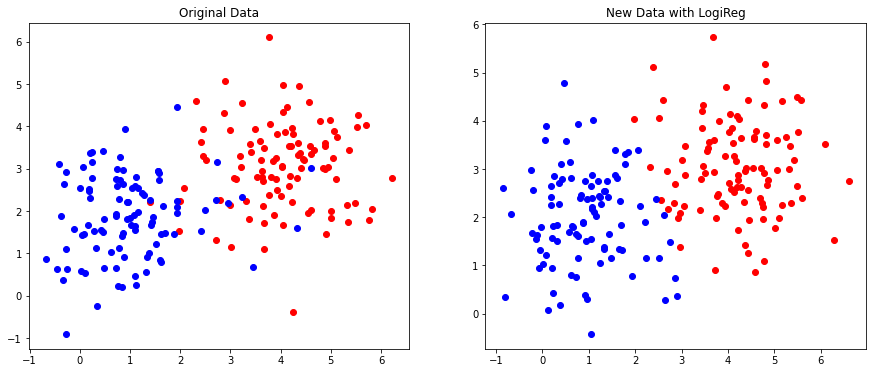

In [42]:
data = np.column_stack(( 
    np.concatenate(( 
        # draw from 2 2-dim. multivariate normal dists.
        np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
        np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) )), 
    # labels corresonding to each distribution
    np.concatenate(( np.zeros(100), np.ones(100) )) ))
np.random.shuffle(data)
# extract X and y from the shuffled data
X = data[:,:2]
y = data[:,2].astype(int)

X_test = np.concatenate(( 
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) ))
np.random.shuffle(X_test)

plt.figure(figsize=((15,6)))
#create an object belonging to our logireg class
log_reg = LogiReg(y=y, X=X)
#fit the data to our model
log_reg.fit()
#predict the test set labels
predictions = log_reg.predict(X_test)

#observe the labels
ones_train = y == 1
zeros_train = y == 0

ones_predict = predictions == 1
zeros_predict = predictions == 0

#graph the labels of the original data
plt.subplot(121)
plt.scatter(X[:,0][ones_train], X[:,1][ones_train],color='red')
plt.scatter(X[:,0][zeros_train], X[:,1][zeros_train],color='blue')
plt.title('Original Data')

#graph the labels of the predicted data
plt.subplot(122)
plt.scatter(X_test[:,0][ones_predict], X_test[:,1][ones_predict],color='red')
plt.scatter(X_test[:,0][zeros_predict], X_test[:,1][zeros_predict],color='blue')
plt.title('New Data with LogiReg')

plt.show()

## Problem 4

Using each of `LogiReg`, `statsmodels`, and `sklearn`, train a logistic regression classifier on $X$ and $y$ to generate a list of predicted labels for $X\_test$. Then, using $y\_test$, print the accuracy scores for each trained model. Compare the accuracies and training/testing time for all three classifiers. Be sure to add a constant feature with each model.

In [55]:
# predefine the true beta
beta = np.random.normal(0, 7, 20)

# X is generated from 2 20-dim. multivariate normal dists.
X = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100) ))
np.random.shuffle(X)
# create y based on the true beta
pred = 1. / (1. + np.exp(-X @ beta))  
y = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

# X_test and y_test are generated similar to X and y
X_test = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20), np.eye(20), 100) ))
np.random.shuffle(X_test)
pred = 1. / (1. + np.exp(-X_test @ beta))
y_test = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

#fit and predict using LogiReg
start = time.time()
log_reg = LogiReg(y=y, X=X)
log_reg.fit()
predictions = log_reg.predict(X_test)
logireg_ac = accuracy_score(y_test, predictions)
ex_time = time.time()-start
print('LogiReg Accuracy:', logireg_ac, 'LogiReg Time:', ex_time)

#fit and predict using Statsmodels
start = time.time()
sm_model = sm.Logit(y, sm.add_constant(X)).fit_regularized(disp=0)  # setting disp=0 turns off printed info
probs = sm_model.predict(sm.add_constant(X_test))  # list of probabilities, not labels
decision = np.zeros_like(probs)
decision[probs>=1/2] = 1
statsmodels_ac = accuracy_score(y_test, decision)
ex_time = time.time()-start
print('StatsModels Accuracy:', statsmodels_ac, 'StatsModels Time:', ex_time)

#fit and predict using Sklearn
start = time.time()
model = LogisticRegression(fit_intercept=True).fit(X, y)  # X before y
sklearn_ac = model.score(X_test, y_test)
ex_time = time.time()-start
print('Sklearn Accuracy:', sklearn_ac, 'Sklearn Time:', ex_time)

LogiReg Accuracy: 0.945 LogiReg Time: 0.6358852386474609
StatsModels Accuracy: 0.935 StatsModels Time: 0.006706953048706055
Sklearn Accuracy: 0.92 Sklearn Time: 0.0014450550079345703


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


## Problem 5

Import the Iris Dataset and perform a train-test split on only the first two columns of the data with `test_size=0.4`. Train a multinomial logistic regression model using the training data with an added constant feature, and generate prediction labels for the test data.

Plot the test data by color using your prediction labels.

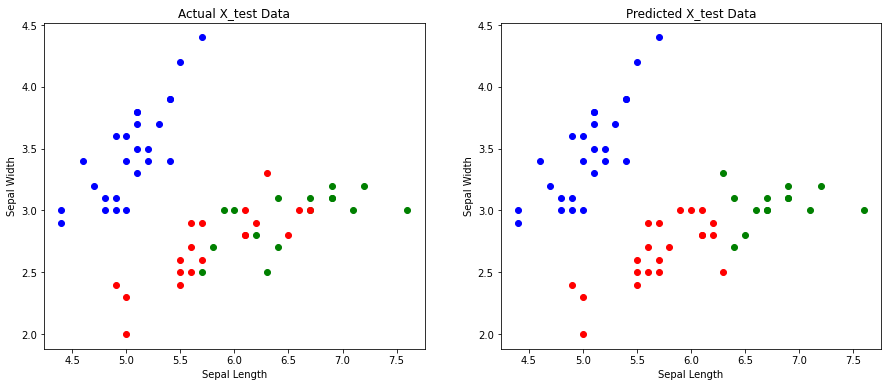

In [83]:
plt.figure(figsize=((15,6)))
#load in the data
iris_data = datasets.load_iris()
X = iris_data['data']
y = iris_data['target']

#train-test split on the first two columns of data with test_size=.4
X_train, X_test, y_train, y_test = train_test_split(X[:,:2],y,test_size=.4)

#train the multinomial model
model = LogisticRegression(multi_class='multinomial',fit_intercept=True).fit(X_train, y_train) # add constant feature
#use our model to predict the labels of x test
predictions = model.predict(X_test)

#observe the labels for the actual and predicted data
twos_test = y_test == 2
ones_test = y_test == 1
zeros_test = y_test == 0

twos_pred = predictions == 2
ones_pred = predictions == 1
zeros_pred = predictions == 0

#plot the labels of the actual data
plt.subplot(121)
plt.scatter(X_test[:,0][twos_test], X_test[:,1][twos_test],color='green')
plt.scatter(X_test[:,0][ones_test], X_test[:,1][ones_test],color='red')
plt.scatter(X_test[:,0][zeros_test], X_test[:,1][zeros_test],color='blue')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Actual X_test Data')

#plot the labels of the predicted data
plt.subplot(122)
plt.scatter(X_test[:,0][twos_pred], X_test[:,1][twos_pred],color='green')
plt.scatter(X_test[:,0][ones_pred], X_test[:,1][ones_pred],color='red')
plt.scatter(X_test[:,0][zeros_pred], X_test[:,1][zeros_pred],color='blue')
plt.xlabel('Sepal Length')
plt.ylabel('Sepal Width')
plt.title('Predicted X_test Data')
plt.show()